# Bayesian Symbolic Regression

## Tutorial: Recovering the exponential learning curve model

In this tutorial, we'll learn how to use Bayesian Symbolic Regression (BSR) as a theorist to recover the exponential learning curve model.

### Installing AutoRA

We begin with installing AutoRA via the pip package manager, and then import the relevant modules:

In [1]:
!pip install autora

import numpy as np
from autora.variable import DV, IV, ValueType, VariableCollection
from autora.skl.bsr import BSRRegressor


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


### Generating Data

Next, we generate a relevant data set. We'll start by setting the relevant meta-parameter, which is the level of noise to add to the ground-truth model.

In [2]:
# general meta parameters
added_noise = 0.01

Next, we set the specific parameters for the exponential learning curve model

In [3]:
# exponential learning curve parameters
exp_learning_resolution = 100
exp_learning_minimum_trial = 1
exp_learning_maximum_trial = exp_learning_resolution
exp_learning_minimum_initial_value = 0
exp_learning_maximum_initial_value = 0.5
exp_learning_lr = 0.03
exp_learning_p_asymptotic = 1.0

We then set up the ground-truth model. To do so, we first define our metadata

In [4]:
def exp_learning_metadata():
    p_initial = IV(
        name="P_asymptotic",
        allowed_values=np.linspace(exp_learning_minimum_initial_value,
                                   exp_learning_maximum_initial_value,
                                   exp_learning_resolution),
        value_range=(exp_learning_minimum_initial_value,
                     exp_learning_maximum_initial_value),
        units="performance",
        variable_label="Asymptotic Performance",
        type=ValueType.REAL
    )

    trial = IV(
        name="trial",
        allowed_values=np.linspace(exp_learning_minimum_trial,
                                   exp_learning_maximum_trial,
                                   exp_learning_resolution),
        value_range=(exp_learning_minimum_trial,
                     exp_learning_maximum_trial),
        units="trials",
        variable_label="Trials",
        type=ValueType.REAL
    )

    performance = DV(
        name="performance",
        value_range=(0, exp_learning_p_asymptotic),
        units="performance",
        variable_label="Performance",
        type=ValueType.REAL
    )

    metadata = VariableCollection(
        independent_variables=[p_initial, trial],
        dependent_variables=[performance],
    )

    return metadata

Then we define our synthetic experiment

In [5]:
def exp_learning_experiment(X: np.ndarray,
                             p_asymptotic: float = exp_learning_p_asymptotic,
                             lr: float = exp_learning_lr,
                             std = added_noise):
    Y = np.zeros((X.shape[0],1))

    for idx, x in enumerate(X):
        p_initial = x[0]
        trial = x[1]
        y = p_asymptotic - (p_asymptotic - p_initial) * np.exp(- lr * trial) + np.random.normal(0, std)
        Y[idx] = y

    return Y

Finally, we define how to generate synthetic data

In [6]:
def exp_learning_data(metadata):

    p_initial_values = metadata.independent_variables[0].allowed_values
    trial_values = metadata.independent_variables[1].allowed_values

    X = np.array(np.meshgrid(p_initial_values, trial_values)).T.reshape(-1,2)
    y = exp_learning_experiment(X, std=0)

    return X, y

With these functions defined, we can now create a data set from a noisy ground-truth model

In [7]:
X, y = exp_learning_data(exp_learning_metadata())

Now let us define the search space, that is, the space of operations to consider when searching over the space of computation graphs. BSR comes with the following built-in operations:

- **\+**: The output of the computation $x_j$ is the sum over its inputs $x_i, x_{ii}$: $x_j = x_i + x_{ii}$.
- **\-**: The output of the computation $x_j$ is the respective difference between its inputs $x_i, x_{ii}$: $x_j = x_i - x_{ii}$.
- __\*__: The output of the computation $x_j$ is the product over its two inputs $x_i, x_{ii}$: $x_j = x_i * x_{ii}$.
- **exp**: The output of the computation $x_j$ is the natural exponential function applied to its input $x_i$: $x_j = \exp(x_i)$.
- **pow2**: The output of the computation $x_j$ is the square function applied to its input $x_i$: $x_j$ = $x_i^2$.
- **pow3**: The output of the computation $x_j$ is the cube function applied to its input $x_i$: $x_j$ = $x_i^3$.
- **sin**: The output of the computation $x_j$ is the sine function applied to its input $x_i$: $x_j = \sin(x_i)$.
- **cos**: The output of the computation $x_j$ is the cosine function applied to its input $x_i$: $x_j = \cos(x_i)$.
- **ln**: The output of the computation $x_j$ is the linear transformation applied to its input $x_i$: $x_j = a * x_i + b$, where $a$ and $b$ are slope and intercept parameters.

The meta-parameters for BSR have default settings, which we will use for this example. Those defaults are as follows:

In [8]:
bsr_estimator = BSRRegressor(
    tree_num=3,
    itr_num=1000,
    val=100,
    beta=-1,
)

With regressor created and all its meta-parameters assigned, we can now fit the regressor to our synthetic data set. That is, we can use the BSRRegressor to recover an equation that it thinks best maps X to y.

In [9]:
bsr_estimator.fit(X,y)

BSRRegressor(itr_num=1000)

Now that we have both our ground-truth and the BSR candidate models, we can plot them and compare results. We define how to create our plot

In [10]:
def plot_exp_learning(model = None):
    plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    import matplotlib.pyplot as plt
    metadata = exp_learning_metadata()

    P_0_list = [0, 0.25, 0.5]
    trial = metadata.independent_variables[1].allowed_values

    for P_0_index, P_0 in enumerate(P_0_list):
        X = np.zeros((len(trial), 2))
        X[:, 0] = P_0
        X[:, 1] = trial

        y = exp_learning_experiment(X, std=0)
        plt.plot(trial, y, label=f"$P_0 = {P_0}$ (Original)", color = plot_colors[P_0_index])
        if model is not None:
            y = model.predict(X)
            plt.plot(trial, y, label=f"$P_0 = {P_0}$ (Recovered)", linestyle="--", color = plot_colors[P_0_index])

    x_limit = [0, metadata.independent_variables[1].value_range[1]]
    y_limit = [0, 1]
    x_label = "Trial $t$"
    y_label = "Performance $P_n$"

    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.xlabel(x_label, fontsize="large")
    plt.ylabel(y_label, fontsize="large")
    plt.legend(loc=4, fontsize="medium")
    plt.title("Exponential Learning", fontsize="x-large")
    plt.show()

And then we pass in our new BSR candidate model to get our visual comparison

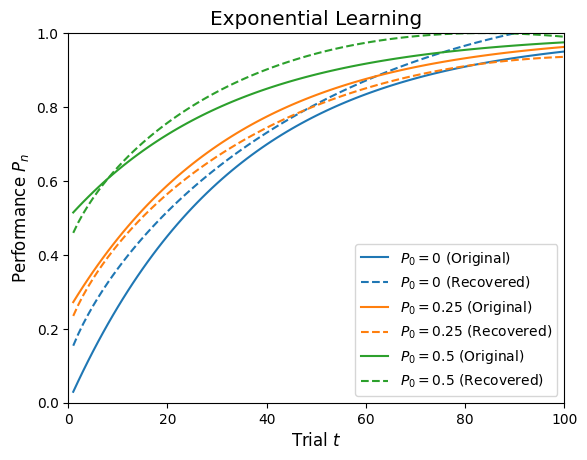

In [11]:
plot_exp_learning(bsr_estimator)
